In [1]:
import json
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
CUSTOMERS_DIR = 'C:/Users/1marc/Desktop/zadanie/Zadanie rekrutacyjne na stanowisko Data Scientist IIIT/'
FILE_NAME = "customers.txt"

In [3]:
def load_valid_rows(file_name: str) -> List:
    result = []
    with open(CUSTOMERS_DIR + file_name, 'r') as f:
        for row in f:
            try:
                result.append(json.loads(row))
            except:
                pass
    return result


def parse_json_objects(fraudsters_na_free: pd.DataFrame) -> pd.DataFrame:
    orders_flat = fraudsters_na_free["orders"].explode()
    orders = pd.json_normalize(orders_flat)
    orders['FraudulentId'] = orders_flat.index
    paymentMethods = pd.json_normalize(fraudsters_na_free['paymentMethods'].explode())
    transactions = pd.json_normalize(fraudsters_na_free['transactions'].explode())
    return orders.merge(transactions, left_on='orderId', right_on='orderId').merge(paymentMethods,
                                                                                   left_on='paymentMethodId',
                                                                                   right_on='paymentMethodId')


def validate_missing_data(fraudsters: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    fraudsters_na_free = fraudsters[
        (fraudsters['orders'].str.len() != 0) & (fraudsters['paymentMethods'].str.len() != 0) & (
                fraudsters['transactions'].str.len() != 0)]

    only_na = fraudsters[~fraudsters.index.isin(fraudsters_na_free.index)]
    return fraudsters_na_free, only_na


def show_confusion_matrix(cm: np.array):
    plt.figure(figsize=(10, 6))
    index = ['Not fraudulent', 'Fraudulent']
    columns = ['Not fraudulent', 'Fraudulent']
    sns.heatmap(pd.DataFrame(cm, columns, index), annot=True, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def show_features_importance(importances: pd.Series):
    plt.barh(np.arange(len(importances)), importances, alpha=0.7)
    plt.yticks(np.arange(.5, len(importances), 1), importances.index)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature importance')
    plt.show()


def show_roc_curve(fpr: np.array, tpr: np.array):
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue',
             label='ROC (AUC = %0.4f)' % auc_score)
    plt.legend(loc='lower right')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

In [4]:
valid_rows = load_valid_rows(FILE_NAME)
fraudsters = pd.json_normalize(valid_rows)
fraudsters['FraudulentId'] = fraudsters.index

In [5]:
fraudsters_na_free, only_na = validate_missing_data(fraudsters)

fraudsters_flat = pd.merge(fraudsters_na_free,
                   parse_json_objects(fraudsters_na_free),
                   left_on='FraudulentId',
                   right_on='FraudulentId').drop(['orders', 'paymentMethods', 'transactions'], axis=1)

In [6]:
only_na.head(5)

,fraudulent,orders,paymentMethods,transactions,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress,FraudulentId
9,True,[],"[{'paymentMethodId': '37264k8rb', 'paymentMeth...",[],ubranch@rivera-parker.info,(772)964-8162x6310,6mpx027neyz6sh04n3ue,86.16.65.228,"6974 Robertson Common Apt. 902\nPort Juanside,...",9
23,True,[],"[{'paymentMethodId': 'e7pkpmorx', 'paymentMeth...",[],guerramichael@hotmail.com,299-883-0904,webmbgi39hwejv3d90kt,245.38.171.222,"13553 Michelle Freeway Apt. 290\nTammyhaven, G...",23
34,False,[],[],[],zbennett@frazier.com,995.449.5115x498,zxdd5co6f5pylq9it4x0,e03d:db6e:f5ca:b9cd:d64f:80fe:6177:26e1,89773 Peterson Course Suite 625\nEast Amandabo...,34
38,False,[],[],[],xwang@white.com,592.309.4963x427,1qj6z7funp3l28ym8trh,7891:9f08:9ac6:c816:7c58:26cd:ff2c:7ddc,"139 Ramirez Island Suite 885\nNew Joan, MT 69993",38
40,True,[],"[{'paymentMethodId': 'vogv964fe', 'paymentMeth...",[],johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,"08238 Kyle Squares Suite 893\nMillermouth, IN ...",40


As we can see above, for some rows values in several columns are empty, so we won't use them further.

In [7]:
fraudsters_flat.head(5)

,fraudulent,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress,FraudulentId,orderId,orderAmount,orderState,orderShippingAddress,transactionId,paymentMethodId,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
0,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",0,vjbdvd,18,pending,"5493 Jones Islands\nBrownside, CA 51896",a9lcj51r,wt07xm68b,18,False,True,card,JCB 16 digit,Citizens First Banks
1,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",0,yp6x27,26,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",y4wcv03i,wt07xm68b,26,False,True,card,JCB 16 digit,Citizens First Banks
2,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,1,nlghpa,45,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",5mi94sfw,41ug157xz,45,False,False,bitcoin,American Express,Bastion Banks
3,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,1,uw0eeb,23,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,br8ba1nu,41ug157xz,23,False,False,bitcoin,American Express,Bastion Banks
4,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,1,bn44oh,43,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",a33145ss,y3xp697jx,43,True,True,bitcoin,VISA 16 digit,Solace Banks


In [8]:
all(fraudsters_flat["orderAmount"] == fraudsters_flat['transactionAmount'])

True

I check if `"orderAmount"` column has the same values as `'transactionAmount'` column.

In [9]:
cols_to_factorize = ["fraudulent", "orderState",
                     'transactionFailed', 'paymentMethodRegistrationFailure',
                     'paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer']

for col in cols_to_factorize:
    fraudsters_flat[col] = pd.factorize(fraudsters_flat[col])[0]

In [10]:
X_cols = ["orderAmount", "orderState",
          'transactionFailed', 'paymentMethodRegistrationFailure',
          'paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer']

Y_cols = ["fraudulent"]

X = fraudsters_flat[X_cols]
y = fraudsters_flat[Y_cols]

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.6, random_state=2)

I encode categorical variables and choose potential explanatory variables, then I split dataset into test and trainging sets. 

In [12]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [13]:
Ntrees = 50
m = np.sqrt(train_X.shape[1]).astype(int)

In [14]:
clf = ensemble.RandomForestClassifier(n_estimators=Ntrees, max_features=m, random_state=0, n_jobs=-1)
clf.fit(train_X, train_y.values.ravel())
clf.score(test_X, test_y)
pred = clf.predict(test_X)

In [15]:
clf_result = precision_recall_fscore_support(test_y, pred)

### Accuracy

In [16]:
accuracy_score(test_y, pred)

0.7887700534759359

Almost 79% of classes were detected properly.

### Confusion matrix

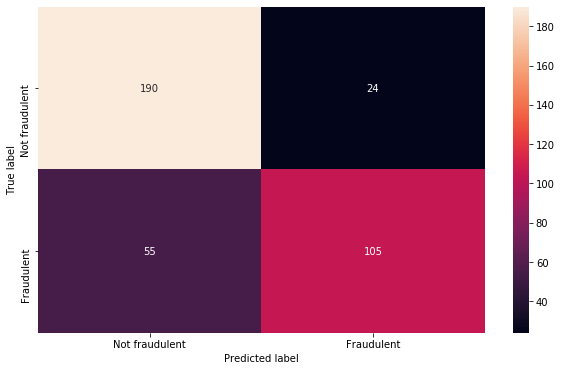

In [17]:
cm_rf = confusion_matrix(test_y, pred)
report_rf = precision_recall_fscore_support(list(np.array(test_y)), list(pred), average='binary')
show_confusion_matrix(cm_rf)

Model detects better `Not fraudulent` class than `Fraudulent`.

### AUC & ROC Curve 

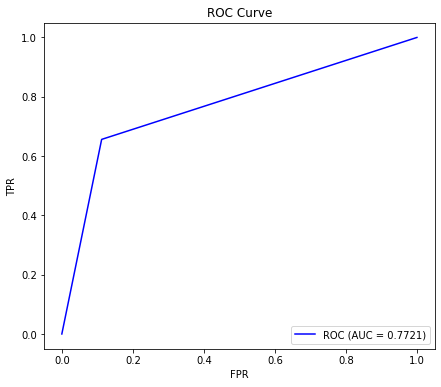

In [18]:
fpr, tpr, _ = roc_curve(test_y, pred)
auc_score = auc(fpr, tpr)
show_roc_curve(fpr, tpr)

AUC score is relativly good.

### Features importance

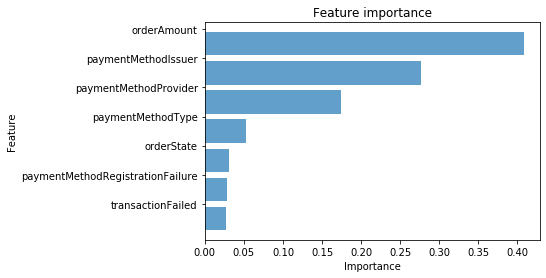

In [19]:
importances = pd.Series(clf.feature_importances_, index=X_cols).sort_values()
show_features_importance(importances)

From the feature importance measures, we see that orderAmount, paymentMethodIssuer and paymentMethodProvider have the highes importance.